<hr style="border:2px solid gray">

##### Author  : SIVA VIKNESH & YOUNES TATARI
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com , younes.tatari@utah.edu/ younes.tatari@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA 
<hr style="border:2px solid gray">

In [2]:
import os
import torch
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

from itertools import combinations
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True, precision=15)

Two dimensional form of Van der pol oscillator:  <br>
Book: Understanding Nonlinear Dynamics By Daniel Kaplan, Leon Glass · 2012
$$
\begin{aligned}
\dot{x} & =  y\\
\dot{y} & = mu(1 - x^a)y -x \\
\end{aligned}
$$

Parameters: \\(mu\\) , \\(a\\) 

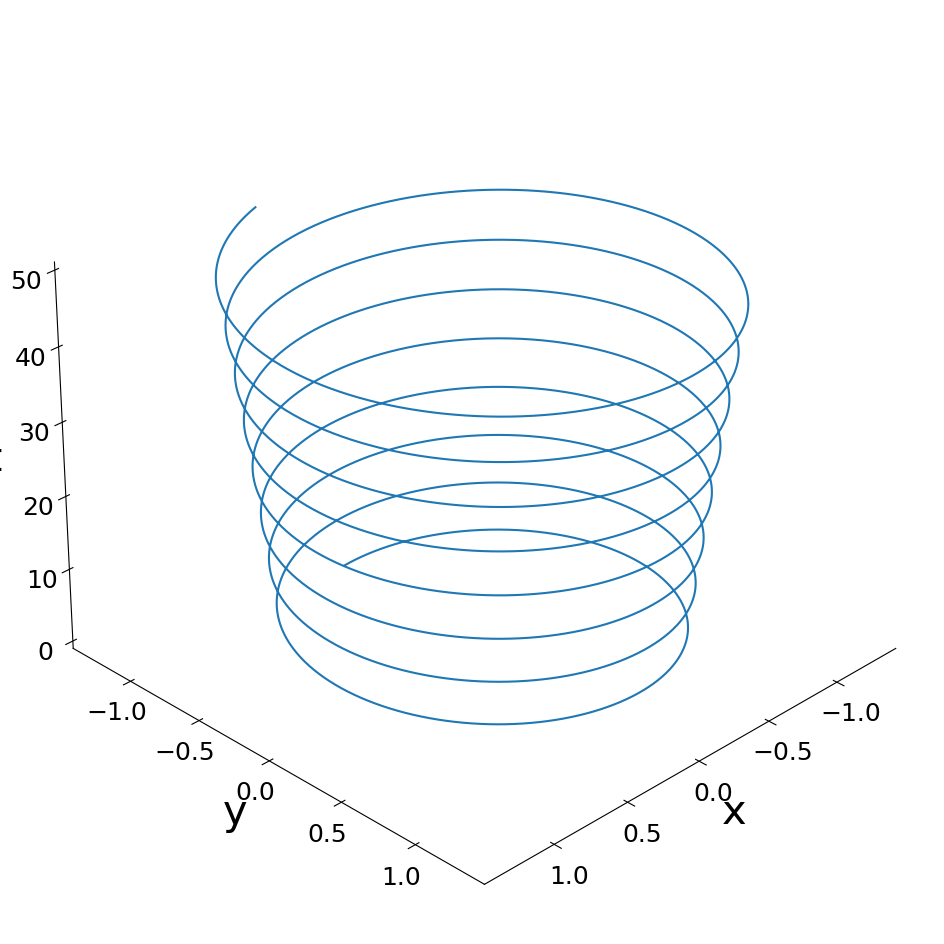

In [4]:
dt = 0.01
T  = 200
t  = np.arange(0,T+dt,dt)
mu = 0.01
a  = 2.15

def oscillator_deriv(x_y, t0, a = a, mu = mu):
    x, y = x_y
    x_powered = np.sign(x) * np.power(np.abs(x), a)
    dxdt = y
    dydt = mu * (1 - x_powered )*y - x
    return [dxdt, dydt]

np.random.seed(123)
x0 = (0, -1)
x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plotting the data
ax.plot(x[t<=50], y[t<=50], t[t<=50])

# Setting labels with Times New Roman font
ax.set_xlabel("x", labelpad=8, fontsize = 30)
ax.set_ylabel("y", labelpad=8, fontsize = 30)
ax.set_zlabel("t", labelpad=8, fontsize = 30)

# Set limits for x and y axes
#ax.set_xlim(-2, 2)
#ax.set_ylim(-2, 2)

# Remove background pane and borders
ax.xaxis.pane.fill = False  # Remove background pane for x-axis
ax.yaxis.pane.fill = False  # Remove background pane for y-axis
ax.zaxis.pane.fill = False  # Remove background pane for z-axis

# Turn off the pane borders
ax.xaxis.pane.set_edgecolor('none')  # No border for x-axis pane
ax.yaxis.pane.set_edgecolor('none')  # No border for y-axis pane
ax.zaxis.pane.set_edgecolor('none')  # No border for z-axis pane

# Remove grid
ax.grid(False)

ax.view_init(30, 45, 0)
# Save figure to a PDF file
plt.savefig('3d_plot.pdf', format='pdf', bbox_inches='tight')

# Display plot
plt.show()

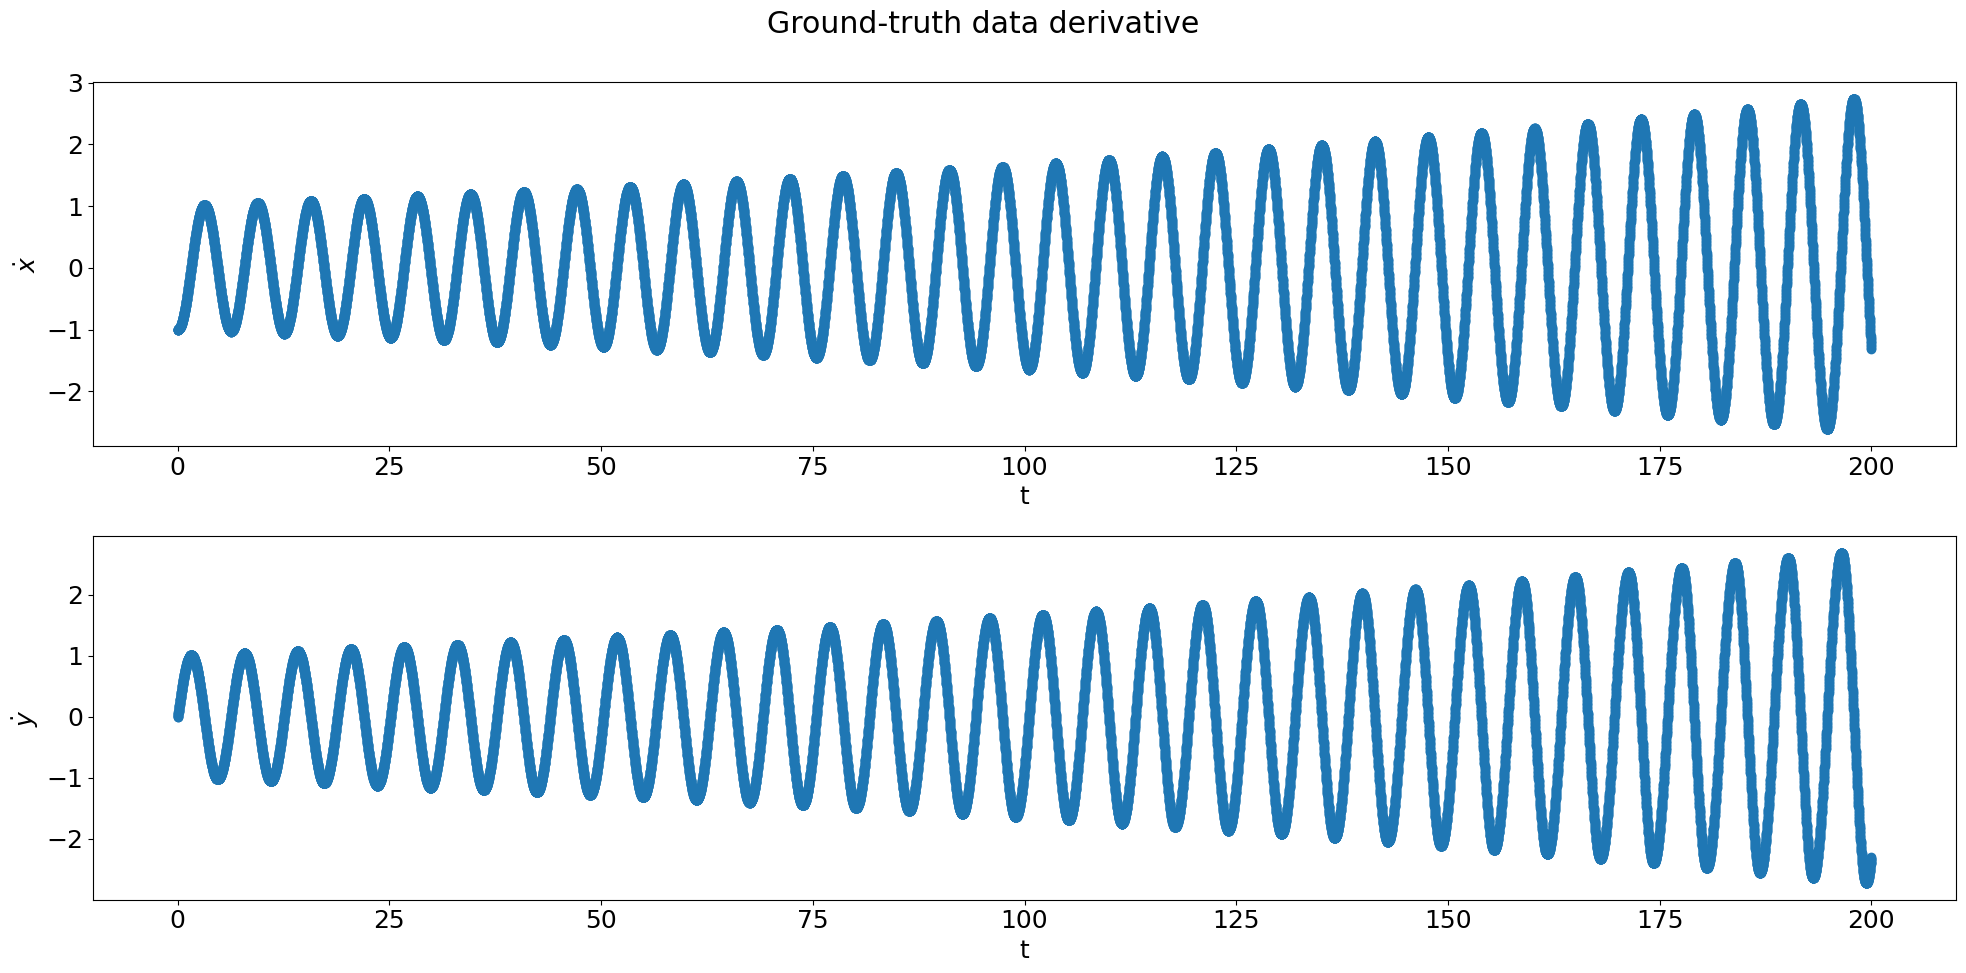

In [5]:
def DERIVATIVE(x, y, a, mu):
    x_powered = np.sign(x) * np.power(np.abs(x), a)
    dxdt = y
    dydt = mu * (1 - x_powered )*y - x
    return np.vstack((dxdt, dydt)).T

A1A2_time_deriv = DERIVATIVE (x, y, a, mu)

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t, A1A2_time_deriv[:, 0], '-o')
ax[0].set(xlabel="t",ylabel=r"$\dot{x}$")

ax[1].plot(t, A1A2_time_deriv[:, 1], '-o')
ax[1].set(xlabel="t",ylabel=r"$\dot{y}$")

fig.tight_layout()
plt.show()

In [6]:
## SINDy Function Definitions
def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))

    # poly order 0
    yout[:,0] = np.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)

    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n): #Solves SINDy's L1 regularized convex optimization problem
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

In [7]:

nums = [2,2.8,3,4,4.5,5]              #numbers in the denominator [ sin(pi/a)]
sin_freq = np.pi / np.array(nums)     #frequencies for sin and cos function

x_exp_powers = [ 1.0]          #coefficients for exponential of x [exp(a*x)] 
y_exp_powers = [ 1.0]          #coefficents for exponential of y [exp(a*y)]

# Define the powers
x_powers = [1, 2.0]
y_powers = [1, 2.0]

def generate_candidates(x_t, sin_freq, x_exp_powers, y_exp_powers, x_powers, y_powers):
    """
    Generates polynomial, sine, cosine, and exponential terms, and their combinations
    based on input data. Handles cases where x_t has dimensions (1000, 2) or (1, 2).
    
    Parameters:
    x_t : array-like of shape (N, 2)
        Input data for N data points with two variables (x and y).
    sin_freq : list of float
        Frequencies for sine and cosine functions.
    x_exp_powers : list of float
        Coefficients for the exponential of x (exp(a*x)).
    y_exp_powers : list of float
        Coefficients for the exponential of y (exp(a*y)).
    
    Returns:
    All_candidates : array-like
        Combined matrix of polynomial, sine, cosine, and exponential terms.
    """
    
    # Extract x and y from x_t
    x = x_t[:, 0]  # First column is x
    y = x_t[:, 1]  # Second column is y
    
    # Polynomial terms (modify poolData if needed to handle both shapes)
    polynomial = poolData(x_t, 2, 1)
    poly_candidate = polynomial[:, 1:]
    
    N_sin_freq = len(sin_freq)
    
    # Fourier terms
    Nsize = poly_candidate.shape[1] * N_sin_freq
    sine_candidate = np.zeros((poly_candidate.shape[0], Nsize))
    cos_candidate = np.zeros((poly_candidate.shape[0], Nsize))
    
    k = 0
    for i in range(poly_candidate.shape[1]):
        for j in range(N_sin_freq):
            sine_candidate[:, k] = np.sin(poly_candidate[:, i] * sin_freq[j])
            cos_candidate[:, k] = np.cos(poly_candidate[:, i] * sin_freq[j])
            k += 1
    
    # Fourier terms * polynomial terms
    xsine_candidate = np.zeros((poly_candidate.shape[0], Nsize * poly_candidate.shape[1]))
    xcos_candidate = np.zeros((poly_candidate.shape[0], Nsize * poly_candidate.shape[1]))
    
    k = 0
    for i in range(Nsize):
        for j in range(poly_candidate.shape[1]):
            xsine_candidate[:, k] = sine_candidate[:, i] * poly_candidate[:, j]
            xcos_candidate[:, k] = cos_candidate[:, i] * poly_candidate[:, j]
            k += 1
    
    # Exponential terms
    x_exp_powered = np.array([np.exp(x * p) for p in x_exp_powers]).T  # Shape (N, len(x_exp_powers))
    y_exp_powered = np.array([np.exp(y * p) for p in y_exp_powers]).T  # Shape (N, len(y_exp_powers))
    
    # Combine x and y exponential terms
    all_exp = np.hstack([x_exp_powered, y_exp_powered])
    
    # Polynomial * exponential terms
    x_exp_combination = np.concatenate([poly_candidate * x_exp[:, None] for x_exp in x_exp_powered.T], axis=1)
    y_exp_combination = np.concatenate([poly_candidate * y_exp[:, None] for y_exp in y_exp_powered.T], axis=1)
    
    # Combine all exponential terms
    all_exp_combinations = np.hstack([all_exp, x_exp_combination, y_exp_combination])

    # Calculate x and y to their respective powers
    x_powered = np.array([np.sign(x) * np.power(np.abs(x), p) for p in x_powers])
    y_powered = np.array([np.sign(y) * np.power(np.abs(y), p) for p in y_powers])

    combination = np.array([x_p * y_p for x_p, y_p in itertools.product(x_powered, y_powered)])
    combination = combination.T
    
    # Combine all candidate terms
    All_candidates = np.hstack((polynomial, sine_candidate, cos_candidate, xsine_candidate, xcos_candidate, all_exp_combinations, combination))
    
    return All_candidates


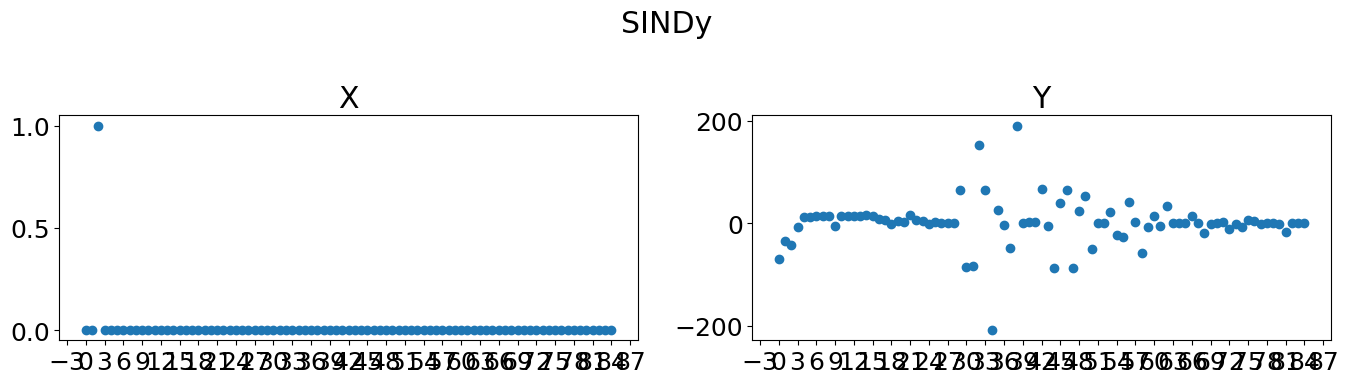

[0.                0.                0.999999999999999 0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.                0.                0.                0.
 0.           

In [8]:
Candidates = generate_candidates (x_t, sin_freq=sin_freq, x_exp_powers=x_exp_powers, y_exp_powers=y_exp_powers, x_powers=x_powers, y_powers=y_powers )

lamb = 0.0075 # sparsification knob lambda
coeff_matrix = sparsifyDynamics(Candidates, A1A2_time_deriv, lamb, 2)
#print(coeff_matrix)
threshold = 0.00001
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('SINDy')

ax[0].plot(coeff_matrix [:, 0], 'o')
ax[0].set_title('X')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(coeff_matrix [:, 1], 'o')
ax[1].set_title('Y')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

print(coeff_matrix[:, 0])
print(coeff_matrix[:, 1])

In [9]:
def SINDy_oscillator_deriv(x_y, t):
    out = generate_candidates (np.array(x_y)[np.newaxis, :], sin_freq=sin_freq, x_exp_powers=x_exp_powers, y_exp_powers=y_exp_powers, x_powers=x_powers, y_powers=y_powers)@coeff_matrix
    return np.squeeze(out).tolist()

np.random.seed(123)
x0 = (0, -1)
x1_t = integrate.odeint(SINDy_oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x1, y1 = x1_t.T

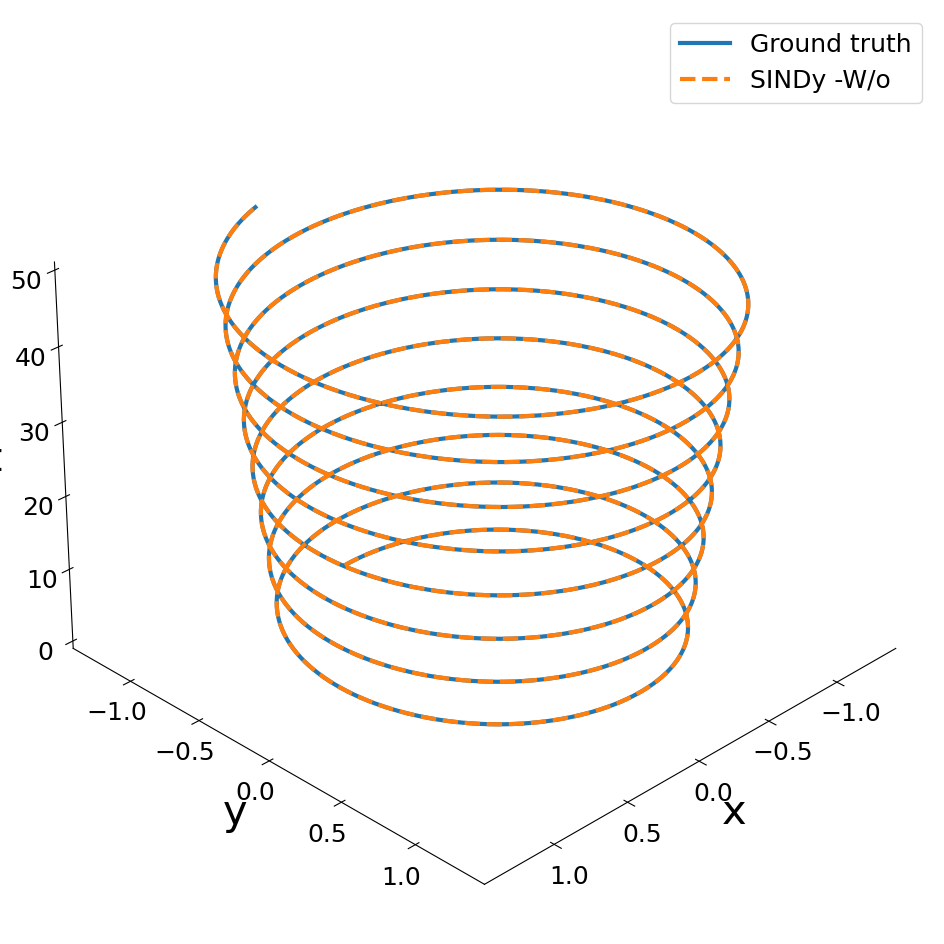

In [22]:


# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plotting the data
ax.plot(x[t<=50],  y[t<=50], t[t<=50], label="Ground truth", linewidth=3)
ax.plot(x1[t<=50], y1[t<=50], t[t<=50], label="SINDy -W/o", linestyle='--', linewidth=3)

# Adding the legend
ax.legend()

# Setting labels with Times New Roman font
ax.set_xlabel("x", labelpad=8, fontsize = 30)
ax.set_ylabel("y", labelpad=8, fontsize = 30)
ax.set_zlabel("t", labelpad=8, fontsize = 30)


# Set limits for x and y axes
#ax.set_xlim(-2, 2)
#ax.set_ylim(-2, 2)

# Remove background pane and borders
ax.xaxis.pane.fill = False  # Remove background pane for x-axis
ax.yaxis.pane.fill = False  # Remove background pane for y-axis
ax.zaxis.pane.fill = False  # Remove background pane for z-axis

# Turn off the pane borders
ax.xaxis.pane.set_edgecolor('none')  # No border for x-axis pane
ax.yaxis.pane.set_edgecolor('none')  # No border for y-axis pane
ax.zaxis.pane.set_edgecolor('none')  # No border for z-axis pane

# Remove grid
ax.grid(False)

ax.view_init(30, 45, 0)
# Save figure to a PDF file
plt.savefig('Comparison(SINDY-Wo).jpeg', dpi = 1200)

# Display plot
plt.show()

In [11]:
print(np.linalg.norm(x1_t - x_t, ord=2) / x.size)

2.649895930572165e-09
